<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template and tests for an LSTM Auto-Encoder


In [1]:
import tensorflow as tf
tf.__version__
tf.config.list_physical_devices('GPU')

'2.2.0'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
! pip install --user -e /global/homes/v/vboehm/codes/SDSS_PAE/    

Obtaining file:///global/homes/v/vboehm/codes/SDSS_PAE
  Attempting uninstall: sdss-pae
    Found existing installation: sdss-pae 0.1.0
    Uninstalling sdss-pae-0.1.0:
      Successfully uninstalled sdss-pae-0.1.0
  Running setup.py develop for sdss-pae


In [4]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Layer, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, UpSampling1D, AveragePooling1D
from tensorflow.keras.layers import RepeatVector, Conv2DTranspose, Flatten
from tensorflow.keras.layers import TimeDistributed, Input, Lambda, Masking, Dropout
import tensorflow.keras.backend as K

In [5]:
def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, padding='valid', output_padding=0, name=None):
    """
        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding, output_padding=(output_padding,0), name=name)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

In [6]:
### settings
# user defined span (following Yip et al and Portillo et al)
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'

root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'
root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_data       = '/global/cscratch1/sd/vboehm/Datasets'

root_prepped    = os.path.join(root_data,'sdss/prepped')

wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000

label           = 'galaxies_quasars_bins1000_wl3388-8318'
label_          = label+'_minz005_maxz036_minSN50'
label_2         = label+'_minz01_maxz036_minSN50_good'+'_10_fully_connected_mean_div_conditional'

seed            = 8720

latent_dim      = 10
network_type    = 'fully_connected'
cond_on         = 'type'

In [7]:
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

In [8]:
### load data and join
res_fluxes, res_masks, res_inv_vars = [], [] ,[]
redshifts, SNs, ras, decs, category, sublabel = [], [], [], [], [], []
for nn in range(0,6):
    res_fluxes_, res_masks_, res_inv_vars_ = np.load(os.path.join(root_prepped,'prepped_data_spectra_%s_batch%d.npy'%(label_,nn)))
    redshifts_, SNs_, ras_, decs_, category_, sublabel_, MJD_, plate_id_, fiber_ =  np.load(os.path.join(root_prepped,'prepped_data_prop_%s_batch%d.npy'%(label_,nn)))
    if nn==0:
        res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel, MJD, plate_id, fiber = res_fluxes_, res_masks_, res_inv_vars_, redshifts_, SNs_, ras_, decs_, category_, sublabel_, MJD_, plate_id_, fiber_
    else:
        res_fluxes   = np.concatenate([res_fluxes, res_fluxes_],axis=0)
        res_masks    = np.concatenate([res_masks, res_masks_],axis=0)
        res_inv_vars = np.concatenate([res_inv_vars, res_inv_vars_],axis=0)
        redshifts    = np.concatenate([redshifts, redshifts_],axis=0)
        SNs          = np.concatenate([SNs, SNs_],axis=0)
        ras          = np.concatenate([ras, ras_],axis=0)
        decs         = np.concatenate([decs, decs_],axis=0)
        category     = np.concatenate([category, category_],axis=0)
        sublabel     = np.concatenate([sublabel, sublabel_],axis=0)
        MJD          = np.concatenate([MJD, MJD_],axis=0)
        plate_id     = np.concatenate([plate_id, plate_id_],axis=0)
        fiber        = np.concatenate([fiber, fiber_],axis=0)
    print(len(res_fluxes_),nn)
    

88152 0
87988 1
88386 2
87950 3
88034 4
26440 5


In [9]:
for ii in range(5):
    print(MJD[ii], plate_id[ii], fiber[ii], ras[ii], decs[ii], redshifts[ii])

b'53473.0' b'2108.0' b'50.0' b'181.9969024658203' b'37.638492584228516' b'0.10390836745500565'
b'56902.0' b'7616.0' b'941.0' b'11.321800231933594' b'21.414342880249023' b'0.32158181071281433'
b'55955.0' b'5406.0' b'136.0' b'189.802734375' b'9.319830894470215' b'0.08376356214284897'
b'55452.0' b'4085.0' b'107.0' b'322.25970458984375' b'6.486550331115723' b'0.23032799363136292'
b'54540.0' b'2786.0' b'390.0' b'213.32225036621094' b'22.519697189331055' b'0.13797487318515778'


In [10]:
def dense_cond_block(x,z,num, non_lin=True):
    x = tf.concat([x,z], axis=1)
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return Reshape((num,1))(x)

def dense_block(x,num, non_lin=True):
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return x

In [11]:
dim = fixed_num_bins

In [12]:
input        = Input(shape=(dim,1))
input_mask   = Input(shape=(dim,1))
input_noise  = Input(shape=(dim,1))
input_type   = Input(shape=(1,1))
input_params = Input(shape=(1,1))

if cond_on=='type':
    z = input_type
if cond_on=='redshift':
    z = input_params

x = dense_block(input,128, non_lin=False)
x = dense_block(x,64)
x = dense_block(x,32)
x = dense_block(x,16)
x = dense_block(x,latent_dim,non_lin=False)
latent = BatchNormalization(trainable=False)(x)
x = Reshape((latent_dim,1))(latent)
x = dense_cond_block(x,z,16)
x = dense_cond_block(x,z,32)
x = dense_cond_block(x,z,64)
x = dense_cond_block(x,z,128, non_lin=False)
x = dense_cond_block(x,z,dim, non_lin=False)
#x = Reshape((dim,1))(x)



def lossFunction(y_true,y_pred,mask,inverse):
        loss = tf.math.square(y_true-y_pred)*inverse
        loss = tf.reduce_mean(tf.boolean_mask(loss,mask))
        return loss
    
from tensorflow.python.keras.engine import data_adapter


class CustomModel(tf.keras.Model):
    def compile(self, optimizer, my_loss,metrics, run_eagerly):
        super().compile(optimizer,metrics, run_eagerly)
        self.my_loss = my_loss

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        input_data = data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            y_pred = self(data, training=True)
            loss_value = self.my_loss(input_data[0][0],y_pred,input_data[0][1],input_data[0][2])

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"training_loss": loss_value}
    
    


In [13]:
tf.random.set_seed(seed)


lstm_ae = CustomModel(inputs=[input,input_mask,input_noise, input_type, input_params], outputs=x)
lstm_ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), my_loss=lossFunction, metrics=[],run_eagerly=False)

# lstm_ae = Model(inputs=[input, input1,input2, input_float], outputs=[x, input1,input2, input_float])
# lstm_ae.compile(optimizer='adam', loss=lossFunction)
print(lstm_ae.summary())

Model: "custom_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1000)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          128128      flatten[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 128)          0           dense[0][0]                      
_______________________________________________________________________________________

In [14]:
def make_scheduler(length, initial_lr,factor=1.2):
    
    def scheduler(epoch, lr):
        if epoch < length:
            lr = initial_lr
            return lr
        else:
            return lr * tf.math.exp(-factor)
        
    return scheduler



In [15]:

DATASET_SIZE = len(res_fluxes)
train_size   = int(0.7* DATASET_SIZE)
test_size    = int(0.1 * DATASET_SIZE)
valid_size   = int(0.2 * DATASET_SIZE)
indices      = np.arange(DATASET_SIZE)

In [16]:
np.random.seed(seed)
np.random.shuffle(indices)

In [17]:
def reshuffle(list_, indices):
    res = []
    for item_ in list_:
        res.append(item_[indices])
    return res

In [18]:
res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel, MJD, plate_id, fiber = reshuffle([res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel,MJD, plate_id, fiber], indices)

In [19]:
def redshift_bin(min_z, max_z, z_array, arrays):
    num  = len(arrays)
    z_array = np.asarray(z_array, dtype=np.float32)
    indx = np.where((z_array>min_z)*(z_array<max_z))[0]
    arrays_new = [arrays[ii][indx] for ii in range(num)]
    print('new datasize: ', len(indx))
    return arrays_new

res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel, MJD, plate_id, fiber = redshift_bin(.1, .36, redshifts, [res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel, MJD, plate_id, fiber])

new datasize:  412847


In [20]:
mean = np.mean(res_fluxes)
std  = np.std(res_fluxes)

#### if only divide by mean
std = mean
mean= 0

In [21]:
print(std)

205161.4829501925


In [22]:
train_data   = np.expand_dims((res_fluxes[:train_size]-mean)/std,-1)
valid_data   = np.expand_dims((res_fluxes[train_size:train_size+valid_size]-mean)/std,-1)
test_data    = np.expand_dims((res_fluxes[-test_size::]-mean)/std,-1)

train_mask   = np.expand_dims(res_masks[:train_size],-1)
valid_mask   = np.expand_dims(res_masks[train_size:train_size+valid_size],-1)
test_mask    = np.expand_dims(res_masks[-test_size::],-1)

train_noise  = np.expand_dims(res_inv_vars[:train_size],-1)*std**2
valid_noise  = np.expand_dims(res_inv_vars[train_size:train_size+valid_size],-1)*std**2
test_noise   = np.expand_dims(res_inv_vars[-test_size::],-1)*std**2

train_params = np.asarray(redshifts, dtype=np.float32)[:train_size]
valid_params = np.asarray(redshifts, dtype=np.float32)[train_size:train_size+valid_size]
test_params  = np.asarray(redshifts, dtype=np.float32)[-test_size::]

train_ras = np.asarray(ras, dtype=np.float32)[:train_size]
valid_ras = np.asarray(ras, dtype=np.float32)[train_size:train_size+valid_size]
test_ras  = np.asarray(ras, dtype=np.float32)[-test_size::]

train_decs = np.asarray(decs, dtype=np.float32)[:train_size]
valid_decs = np.asarray(decs, dtype=np.float32)[train_size:train_size+valid_size]
test_decs  = np.asarray(decs, dtype=np.float32)[-test_size::]

train_cat = category[:train_size]
valid_cat = category[train_size:train_size+valid_size]
test_cat  = category[-test_size::]

train_labels = sublabel[:train_size]
valid_labels = sublabel[train_size:train_size+valid_size]
test_labels  = sublabel[-test_size::]

valid_MJD = MJD[train_size:train_size+valid_size]
test_MJD = MJD[-test_size::]

valid_plate_id = plate_id[train_size:train_size+valid_size]
test_plate_id = plate_id[-test_size::]

valid_fiber = fiber[train_size:train_size+valid_size]
test_fiber = fiber[-test_size::]

[b'' b'AGN' b'AGN BROADLINE' b'BROADLINE' b'STARBURST'
 b'STARBURST BROADLINE' b'STARFORMING' b'STARFORMING BROADLINE'] [0 1 2 3 4 5 6 7]


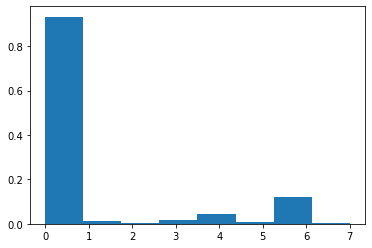

In [23]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_labels)
train_types = le.transform(train_labels)
valid_types = le.transform(valid_labels)
test_types = le.transform(test_labels)
print(le.classes_, le.transform(le.classes_))

_ = plt.hist(test_types,density=True, bins=8)

In [24]:
train_types  = train_types.astype('float64').reshape((-1,1,1))
train_params = train_params.astype('float64').reshape((-1,1,1))
valid_types  = valid_types.astype('float64').reshape((-1,1,1))
valid_params = valid_params.astype('float64').reshape((-1,1,1))
test_types  = test_types.astype('float64').reshape((-1,1,1))
test_params = test_params.astype('float64').reshape((-1,1,1))

In [25]:
np.savez(os.path.join(root_model_data,'train_%s.npy'%label_2),np.squeeze(train_data),np.squeeze(train_mask),np.squeeze(train_noise),train_params,train_ras, train_decs, train_cat, train_types)

In [26]:
np.savez(os.path.join(root_model_data,'valid_%s.npy'%label_2),np.squeeze(valid_data),np.squeeze(valid_mask),np.squeeze(valid_noise),valid_params,valid_ras, valid_decs, valid_cat, valid_types, valid_MJD, valid_plate_id, valid_fiber)

In [27]:
np.savez(os.path.join(root_model_data,'test_%s.npy'%label_2),np.squeeze(test_data),np.squeeze(test_mask),np.squeeze(test_noise),test_params,test_ras, test_decs, test_cat, test_types, test_MJD, test_plate_id, test_fiber)

In [28]:
def training_cycle(BATCH_SIZE, n_epochs, lr_anneal, lr_initial, reduce_fac): 
    scheduler = make_scheduler(lr_anneal, lr_initial, reduce_fac)
    callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    history = lstm_ae.fit(x=(train_data,train_mask,train_noise, train_types, train_params), batch_size=BATCH_SIZE, epochs=n_epochs, callbacks=[callback])
    return history

In [29]:
def custom_metric(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]
    valid_loss = np.mean(loss[np.where(y_true[1])])
    return valid_loss

In [30]:
def bootstrap(train_data, batch_size):
    index   = np.arange(len(train_data[0]))
    metrics = []
    for ii in range(10):
        print(ii)
        sample = np.random.choice(index, size=batch_size, replace=False, p=None)
        res_train = lstm_ae.predict((train_data[0][sample],train_data[1][sample],train_data[2][sample], train_data[3][sample],train_data[4][sample]))
        metric    = custom_metric((train_data[0][sample],train_data[1][sample],train_data[2][sample], train_data[3][sample],train_data[4][sample]),res_train)
        metrics.append(metric)
    return metrics

In [31]:
histories =[]
for batchsize, nepochs, lr_ann in zip([32,64],[30,20],[28,18]):
    histories.append(training_cycle(batchsize, nepochs, lr_ann, 1e-3, 0.5))
    res_valid = lstm_ae.predict((valid_data,valid_mask,valid_noise, valid_types, valid_params))
    print(custom_metric((valid_data,valid_mask,valid_noise, valid_types, valid_params),res_valid))
    res_train = lstm_ae.predict((train_data[:len(valid_data)],train_mask[:len(valid_data)],train_noise[:len(valid_data)],train_types[:len(valid_data)], train_params[:len(valid_data)]))
    print(custom_metric((train_data[:len(valid_data)],train_mask[:len(valid_data)],train_noise[:len(valid_data)],train_types[:len(valid_data)], train_params[:len(valid_data)]),res_train))

Epoch 1/30
10215/10215 [==============================] - 33s 3ms/step - training_loss: 3.9279 - lr: 0.0010
Epoch 2/30
10215/10215 [==============================] - 22s 2ms/step - training_loss: 2.2780 - lr: 0.0010
Epoch 3/30
10215/10215 [==============================] - 22s 2ms/step - training_loss: 2.0708 - lr: 0.0010
Epoch 4/30
10215/10215 [==============================] - 22s 2ms/step - training_loss: 1.8842 - lr: 0.0010
Epoch 5/30
10215/10215 [==============================] - 22s 2ms/step - training_loss: 1.9089 - lr: 0.0010
Epoch 6/30
10215/10215 [==============================] - 22s 2ms/step - training_loss: 1.7637 - lr: 0.0010
Epoch 7/30
10215/10215 [==============================] - 22s 2ms/step - training_loss: 1.7502 - lr: 0.0010
Epoch 8/30
10215/10215 [==============================] - 21s 2ms/step - training_loss: 1.7647 - lr: 0.0010
Epoch 9/30
10215/10215 [==============================] - 22s 2ms/step - training_loss: 1.7283 - lr: 0.0010
Epoch 10/30
10215/10215 [===

In [37]:
for label in np.arange(7):
    print(le.inverse_transform([label]))
    index = np.where(valid_types==label)[0]
    res_valid = lstm_ae.predict((valid_data[index],valid_mask[index],valid_noise[index], valid_types[index], valid_params[index]))
    print('validation: ', custom_metric((valid_data[index],valid_mask[index],valid_noise[index], valid_types[index], valid_params[index]),res_valid))
    index = np.where(train_types==label)[0]
    lng   = min(len(res_valid),len(index))
    res_train = lstm_ae.predict((train_data[index][:lng],train_mask[index][:lng],train_noise[index][:lng],train_types[index][:lng], train_params[index][:lng]))
    print('training: ', custom_metric((train_data[index][:lng],train_mask[index][:lng],train_noise[index][:lng],train_types[index][:lng], train_params[index][:lng]),res_train))

[b'']
validation:  1.175256979463938
training:  1.1923269623546873
[b'AGN']
validation:  1.553184804907516
training:  1.522500852284251
[b'AGN BROADLINE']
validation:  3.2773493310314814
training:  2.942196280169367
[b'BROADLINE']
validation:  2.5956523604276716
training:  2.6677419657570316
[b'STARBURST']
validation:  2.2804517995166678
training:  1.6208755716436891
[b'STARBURST BROADLINE']
validation:  2.8313561880146327
training:  3.0024722726375317
[b'STARFORMING']
validation:  1.3991452878323578
training:  1.4029762333996765


In [38]:
valid_data[index[0],:,:].shape

(1000, 1)

In [39]:
path = os.path.join(root_models,'full_ae_%s_decoder'%label_2)
lstm_ae.save(path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/full_ae_galaxies_quasars_bins1000_wl3388-8318_minz01_maxz036_minSN50_good_10_fully_connected_mean_div_conditional_decoder/assets


In [ ]:
res_valid = lstm_ae.predict((valid_data,valid_mask,valid_noise, valid_types, valid_params))
custom_metric((valid_data,valid_mask,valid_noise, valid_types, valid_params),res_valid)

In [ ]:
bootstrap([train_data,train_mask,train_noise, train_types, train_params], batch_size=len(valid_data))

In [ ]:
# plt.plot(np.append(histories[0].history['training_loss'],histories[1].history['training_loss']))
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
### concatenate and split input

def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    new_model = Sequential()
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(ix, curr_layer)
        new_model.add(curr_layer)
    return new_model

In [ ]:
lstm_ae.get_layer(index=9)

In [ ]:
encoder = extract_layers(lstm_ae,2,10)

#decoder = extract_layers(lstm_ae,10,22)

In [ ]:
encoder.build((None,fixed_num_bins,1))
#decoder.build((None,latent_dim))

In [ ]:
encoder.summary()
decoder.summary()

In [ ]:
encoded_valid = encoder.predict(valid_data)
encoded_train = encoder.predict(train_data)
encoded_test = encoder.predict(test_data)

In [ ]:
decoded_valid = decoder.predict(encoded_valid)
decoded_train = decoder.predict(encoded_train)
decoded_test = decoder.predict(encoded_test)

In [ ]:
path = os.path.join(root_models,'encoder_%s'%label_2)
encoder.save(path)
path = os.path.join(root_models,'decoder_%s'%label_2)
decoder.save(path)
print(path)

In [ ]:
path = os.path.join(root_models,'encoder_%s'%label_2)
encoder = tf.keras.models.load_model(path)
path = os.path.join(root_models,'decoder_%s'%label_2)
decoder = tf.keras.models.load_model(path)

In [ ]:
np.save(os.path.join(root_encoded,'encoded_%s.npy'%label_2),[encoded_train, encoded_valid, encoded_test])
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s.npy'%label_2), allow_pickle=True)

In [ ]:
np.save(os.path.join(root_decoded,'decoded_%s.npy'%label_2),[decoded_train,decoded_valid, decoded_test, mean])

In [ ]:
_=plt.hist(encoded_valid.flatten(),bins=1000,density=True, log=True)
_=plt.hist(encoded_train[:len(encoded_valid)].flatten(),bins=1000,density=True, alpha=0.5, log=True)

In [ ]:
len(encoded_valid)

In [ ]:
lims = 50

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid_params, cmap='nipy_spectral',s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_train[:47000,ii],encoded_train[:47000,jj],c=train_params[:47000], cmap='nipy_spectral',s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(sublabel)
print(le.classes_, le.transform(le.classes_))

In [ ]:
lims = 50

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=le.transform(valid_labels), cmap='Set1', s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_train[:47000,ii],encoded_train[:47000,jj],c=le.transform(train_labels)[:47000], cmap='Set1', s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

In [ ]:
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            fig, ax = plt.subplots(5,5, figsize=(25,15))
            ax = ax.flatten()
            for nn, ii in enumerate(np.arange(25)):
                ax[nn].plot(new_wl[:-1], (np.squeeze(valid_data*std)[ii]+mean)*np.squeeze(valid_mask)[ii], )
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid*std)[ii]+mean)*np.squeeze(valid_mask)[ii], color='orange')
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid*std)[ii]+mean), color='red')
                ax[nn].text(0.05, 0.92, r'z=%.2f'%valid_params[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.82, r'label=%s,%s'%(valid_labels[ii],valid_cat[ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
plt.show()

In [ ]:
enc = encoder.predict(train_data)

In [ ]:
sens=[]
for ii in range(latent_dim):
    res = np.mean(enc,axis=0)
    res[ii]+=1
    sens+=[res]
for ii in range(latent_dim):
    res = np.mean(enc,axis=0)
    res[ii]-=1
    sens+=[res]
sens+=[np.mean(enc,axis=0)]
sens = np.asarray(sens)
test = decoder.predict(sens)

for ii in range(8):
    plt.plot(test[ii]-test[8+ii])
    plt.show()